## 1. Perkenalan 

Nama : Evan Aprillio B  
Batch : RMT-019  
Objective : Membuat model CNN untuk membandingkan wajah menggunakan masker dan wajah tidak menggunakan masker

Link Dataset : https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset  

Link HuggingFace: https://huggingface.co/spaces/EvanAB/M2EvanAB

## 2. Import Library

In [15]:
#import library
import os
import glob #gunakan modul glob
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import pathlib

#import sklearn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve


#import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import load_img
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import warnings
warnings.filterwarnings('ignore')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8473299463889035808
xla_global_id: -1
]


## 3. Data Loading

In [16]:
#direktori data train,val,dan test
train_dir = r"E:\Project\Face Mask Dataset\Train"
test_dir=r"E:\Project\Face Mask Dataset\Test"
val_dir=r"E:\Project\Face Mask Dataset\Validation"

In [17]:
train_path = pathlib.Path(train_dir)
test_path = pathlib.Path(test_dir)
val_path = pathlib.Path(val_dir)

## 4. EDA

#### Cek jumlah data setiap set

In [18]:
#cek jumlah data setiap set
def check_dir(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'jumlah {label} : {num_data}')

print('train set: \n' + '='*50) 
check_dir(train_path,['WithMask','WithoutMask'])

print('\ntest set: \n' + '='*50) 
check_dir(test_path,['WithMask','WithoutMask'])

print('\nvalidation set: \n' + '='*50) 
check_dir(val_path,['WithMask','WithoutMask'])

train set: 


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\Project\\Face Mask Dataset\\Train\\WithMask'

#### Cek ukuran gambar

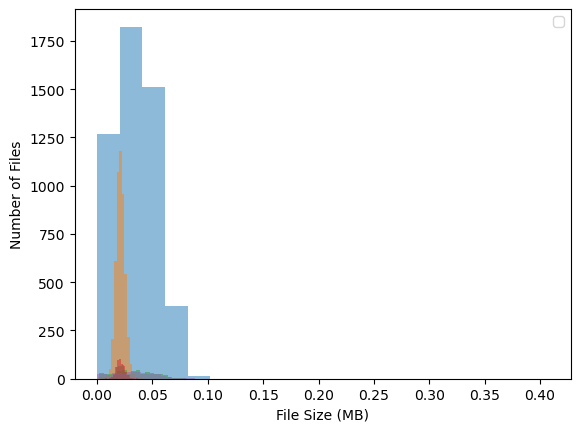

In [54]:
# Path direktori tempat data gambar berada
dir_paths = [
    r"E:\Project\Face Mask Dataset\Train\WithMask",
    r"E:\Project\Face Mask Dataset\Train\WithoutMask",
    r"E:\Project\Face Mask Dataset\Test\WithMask",
    r"E:\Project\Face Mask Dataset\Test\WithoutMask",
    r"E:\Project\Face Mask Dataset\Validation\WithMask",
    r"E:\Project\Face Mask Dataset\Validation\WithoutMask"
]

# Buat list yang akan berisi ukuran file dari setiap gambar untuk setiap direktori
file_sizes = [[] for _ in range(len(dir_paths))]

# Iterasi pada setiap file di setiap direktori dan hitung ukurannya
for i, dir_path in enumerate(dir_paths):
    for file in os.listdir(dir_path):
        file_sizes[i].append(os.path.getsize(os.path.join(dir_path, file)))

    # Konversi ukuran file dari byte ke megabyte
    file_sizes[i] = [size/(1024*1024) for size in file_sizes[i]]

    # Tampilkan histogram ukuran file
    plt.hist(file_sizes[i], bins=20, alpha=0.5,)

plt.xlabel('File Size (MB)')
plt.ylabel('Number of Files')
plt.legend()
plt.show()

1. File image yang memiliki ukuran paling besar ada di dataset train dan ukuran memorinya sebesar 100kb

#### Lihat 5 gambar random disetiap kelas

Class: WithMask


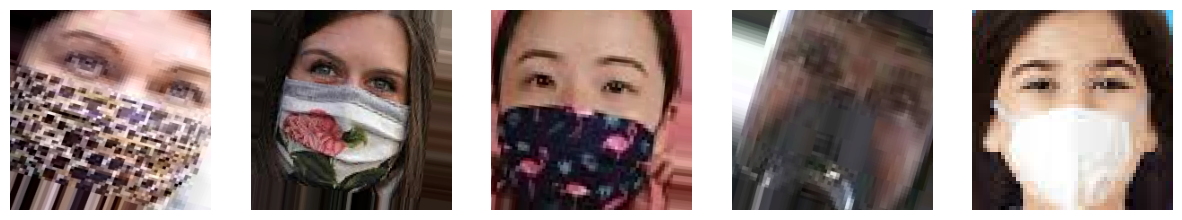

Class: WithoutMask


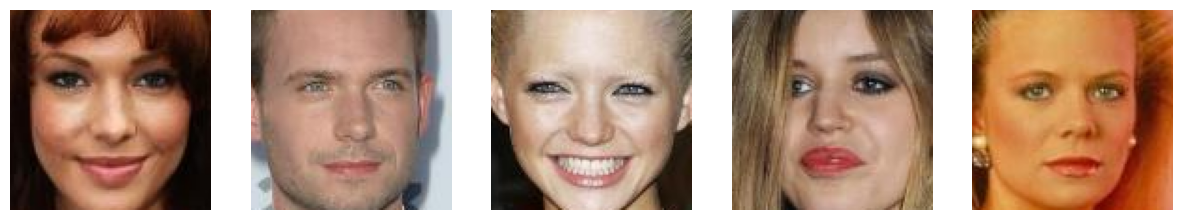

In [55]:
dir_path = r"E:\Project\Face Mask Dataset\Train"

# list semua nama file di direktori
files = os.listdir(dir_path)

# buat dictionary untuk menyimpan nama file berdasarkan class
class_files = {'WithMask': [], 'WithoutMask': []}

# iterasi pada setiap file dan tambahkan ke dictionary sesuai classnya
for file in files:
    if os.path.isdir(os.path.join(dir_path, file)):
        for f in os.listdir(os.path.join(dir_path, file)):
            if 'WithoutMask' in file:
                class_files['WithoutMask'].append(os.path.join(file, f))
            elif 'WithMask' in file:
                class_files['WithMask'].append(os.path.join(file, f))

# tampilkan 5 gambar random dari setiap class
for class_name in class_files:
    print(f"Class: {class_name}")
    plt.figure(figsize=(15,5))
    for i in range(5):
        file = random.choice(class_files[class_name])
        img = plt.imread(os.path.join(dir_path, file))
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

dari data terlihat perbedaan antara ke 2 kelas:
1. Dalam Kelas WithoutMask ada objek mata,hidung,dan mulut sedangkan di WithMask hanya ada mata dan masker saja

In [56]:

def visualize_img(random_data, labels=None):
  fig, axes= plt.subplots(1,5, figsize=(15,12))
  for i, image_path in enumerate(random_data):
    image= plt.imread(image_path)
    axes[i].imshow(image, cmap='gray') # bisa tanpa cmap kalau bener2 RGB
    axes[i].set_title(f'{labels}, {image.shape}')
    axes[i].axis('off')
  plt.show()
     

#### Membuat label disetiap dataset

In [57]:
#data Train
train_data = {'path': [], 'filename': [], 'label': []}

for dirpath, dirnames, filenames in os.walk(train_path):
    for f in filenames:
        train_data['path'].append(os.path.join(dirpath, f))
        train_data['filename'].append(f)
        label = os.path.basename(dirpath).replace('_', ' ')
        train_data['label'].append(label)


train_data_df = pd.DataFrame(train_data)
train_data_df.head(3)

,path,filename,label
0,E:\Project\Face Mask Dataset\Train\WithMask\10...,10.png,WithMask
1,E:\Project\Face Mask Dataset\Train\WithMask\10...,100.png,WithMask
2,E:\Project\Face Mask Dataset\Train\WithMask\10...,1004.png,WithMask


In [58]:
#data validation
val_data = {'path': [], 'filename': [], 'label': []}

for dirpath, dirnames, filenames in os.walk(val_path):
    for f in filenames:
        val_data['path'].append(os.path.join(dirpath, f))
        val_data['filename'].append(f)
        label = os.path.basename(dirpath).replace('_', ' ')
        val_data['label'].append(label)


val_data_df = pd.DataFrame(val_data)
val_data_df.head(3)

,path,filename,label
0,E:\Project\Face Mask Dataset\Validation\WithMa...,1002.png,WithMask
1,E:\Project\Face Mask Dataset\Validation\WithMa...,1003.png,WithMask
2,E:\Project\Face Mask Dataset\Validation\WithMa...,1176.png,WithMask


In [59]:
#data test
test_data = {'path': [], 'filename': [], 'label': []}

for dirpath, dirnames, filenames in os.walk(test_path):
    for f in filenames:
        test_data['path'].append(os.path.join(dirpath, f))
        test_data['filename'].append(f)
        label = os.path.basename(dirpath).replace('_', ' ')
        test_data['label'].append(label)


test_data_df = pd.DataFrame(test_data)
test_data_df.head(3)

,path,filename,label
0,E:\Project\Face Mask Dataset\Test\WithMask\116...,1163.png,WithMask
1,E:\Project\Face Mask Dataset\Test\WithMask\117...,1174.png,WithMask
2,E:\Project\Face Mask Dataset\Test\WithMask\117...,1175.png,WithMask


In [60]:
#mebuat label baru untuk evaluasi
test_data_df['label_encoded'] = test_data_df['label'].apply(lambda x: 0 if x == 'WithMask' else 1)
test_data_df

,path,filename,label,label_encoded
0,E:\Project\Face Mask Dataset\Test\WithMask\116...,1163.png,WithMask,0
1,E:\Project\Face Mask Dataset\Test\WithMask\117...,1174.png,WithMask,0
2,E:\Project\Face Mask Dataset\Test\WithMask\117...,1175.png,WithMask,0
3,E:\Project\Face Mask Dataset\Test\WithMask\120...,1203.png,WithMask,0
4,E:\Project\Face Mask Dataset\Test\WithMask\136...,1361.png,WithMask,0
...,...,...,...,...
987,E:\Project\Face Mask Dataset\Test\WithoutMask\...,967.png,WithoutMask,1
988,E:\Project\Face Mask Dataset\Test\WithoutMask\...,972.png,WithoutMask,1
989,E:\Project\Face Mask Dataset\Test\WithoutMask\...,973.png,WithoutMask,1
990,E:\Project\Face Mask Dataset\Test\WithoutMask\...,998.png,WithoutMask,1


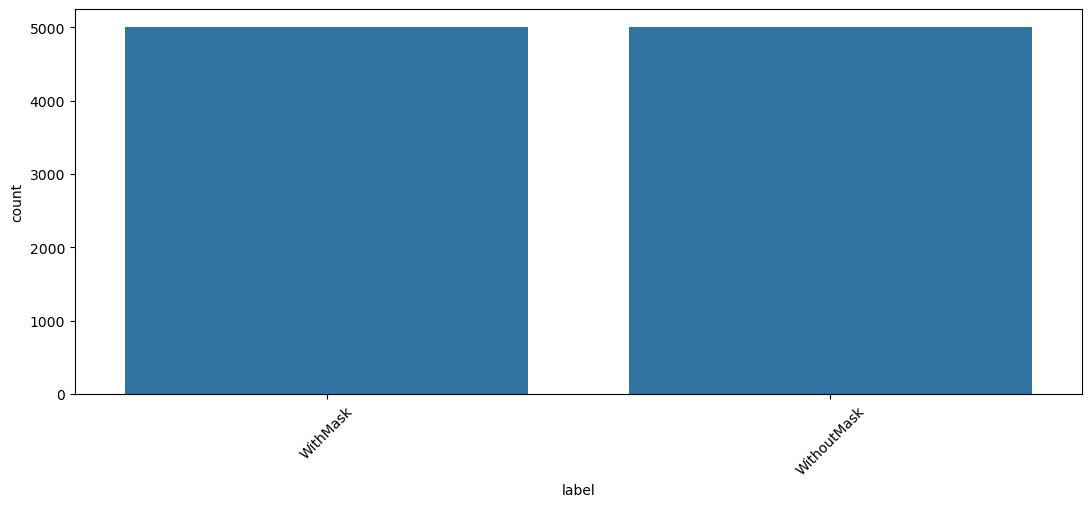

In [61]:
train_data_df['label'].value_counts()

plt.figure(figsize = (13,5))
sns_cntplot = sns.countplot(x='label', data=train_data_df)
plt.xticks(rotation=45);

Jumlah ukuran kelas sudah seimbang yaitu sama sama memiliki 5000 data

#### Melihat shapes dari dataset

In [62]:
shapes_train = [] 

for _, d in train_data_df.iterrows():
    img = load_img(d['path'])
    shapes_train.append(img.size)

shapes_train = pd.DataFrame(data = shapes_train, columns = ['Height', 'Width'], dtype='int64')
shapes_train['Size'] = + shapes_train['Height'] *shapes_train['Width']

shapes_train.describe()

,Height,Width,Size
count,10000.000000,10000.000000,10000.000000
mean,153.102800,153.102800,27402.636200
std,62.948909,62.948909,20074.594539
min,25.000000,25.000000,625.000000
25%,102.000000,102.000000,10404.000000
50%,115.000000,115.000000,13225.000000
75%,224.000000,224.000000,50176.000000
max,563.000000,563.000000,316969.000000


dari data terlihat bahwa :
1. Ada 10rb data train  
2. Tinggi gambar paling besar adalah 563 pixel dan lebar paling besar adalah 563. kemungkinan besar dimiliki oleh gambar yang sama 
3. gambar terbesar memiliki 316969 pixel


## 5. Data Prepocessing

In [63]:
#menyamakan besar tinggi dan lebar gambar
img_height= 220
img_width= 220
batch_size= 64

In [64]:
# Preprocess data
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=444,
    image_size=(img_height,img_width),
    batch_size= batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=444,
    image_size=(img_height,img_width),
    batch_size= batch_size,
    shuffle=False
)

testGen = ImageDataGenerator()
test_ds = testGen.flow_from_dataframe(dataframe = test_data_df,
                                     x_col = 'path',
                                     y_col = 'label',
                                     target_size = (img_height,img_width),
                                     class_mode = 'binary',
                                     batch_size = batch_size,
                                     image_size=(img_height,img_width),
                                     shuffle = False)


Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 validated image filenames belonging to 2 classes.


In [65]:
print(train_ds.class_names)

['WithMask', 'WithoutMask']


WithMask = 0  
WithoutMask = 1

In [66]:
#cek kelas
list_class= train_ds.class_names
nama_class= 'WithoutMask'
class_index= list_class.index(nama_class)
print(class_index) 

1


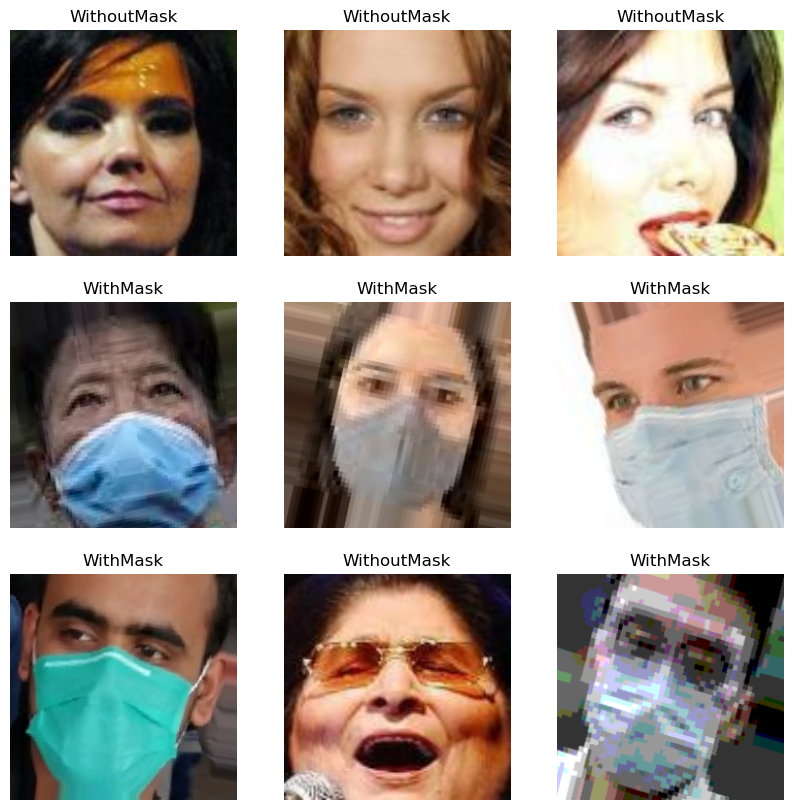

In [67]:
#melihat gambar di train
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax= plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(list_class[labels[i]])
    plt.axis('off')

In [68]:
#lihat ukuran image dan btach
for image_batch , label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(64, 220, 220, 3)
(64,)


## 6. Modelling

In [69]:
#setting cache dan prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Membuat Model tanpa data Augmentasi

In [70]:
seed=20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [71]:
inputs= (img_height, img_width,3)
model_seq_noAug = Sequential([
    layers.Conv2D(20, (5, 5), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(50, (5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_seq_noAug.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
model_seq_noAug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 216, 216, 20)   │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 108, 108, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 104, 104, 50)   │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 52, 52, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 135200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    67,600,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,627,571 (257.98 MB)

 Trainable params: 67,627,571 (257.98 MB)

 Non-trainable params: 0 (0.00 B)

Penjelasan Model :
1. Model yang digunakan adalah model sequential
2. layer pertama input yang diubah menjadi rentang 0-1 dengan cara nilai pixel gambar akan dibagi dengan 255
3. hidden layes ke 1 adalah layers dengan 16 neuron dengan ukuran kernel 3x3 menggunakan activation function Relu
4. hidden layers ke 2 adalah layers Maxpooling 
5. hidden layers ke 3 adalah layers konvolusi dengan neuron sebanyak 32 dan kernel 3 dan menggunakan padding same dan activation Relu
6. flatten
7. layer dropout
8. hidden layer fully connected dengan neuron 128
9. layer batchnormalization untuk menormalkan konvergensi model
10. output layers dengan units=1 menggunakan optimizer adam dan loss= binary crossentropy (karena fungsi model ini untuk pengklasifikasian binary)

In [72]:
## Plot layer
tf.keras.utils.plot_model(model_seq_noAug,show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [73]:
from tensorflow.keras.utils import plot_model
import graphviz
plot_model(model_seq_noAug, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [74]:
#training model
epochs=10
history_seq_noAug= model_seq_noAug.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[callback]
)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.8121 - loss: 149.6424 - val_accuracy: 0.9450 - val_loss: 0.1255
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9656 - loss: 0.1036 - val_accuracy: 0.9375 - val_loss: 0.1635
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9798 - loss: 0.0619 - val_accuracy: 0.9538 - val_loss: 0.1099
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9832 - loss: 0.0464 - val_accuracy: 0.9737 - val_loss: 0.0903
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9945 - loss: 0.0188 - val_accuracy: 0.9762 - val_loss: 0.0539
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9927 - loss: 0.0268 - val_accuracy: 0.9775 - val_loss: 0.0729
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9941 - loss: 0.0211 - val_accuracy: 0.9663 - val_loss: 0.1301
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9864 - loss: 0.0419 - val_ac

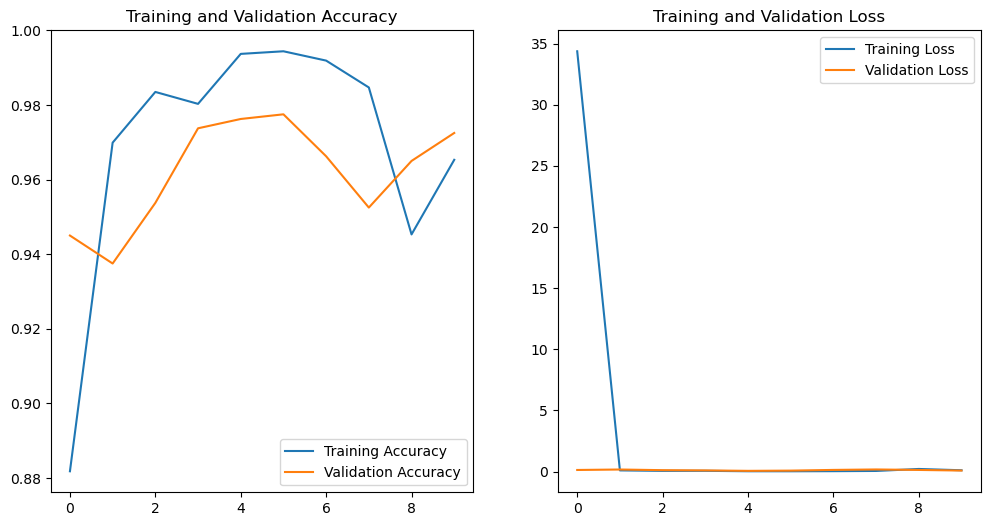

In [75]:
#melihat plot model
acc = history_seq_noAug.history['accuracy']
val_acc = history_seq_noAug.history['val_accuracy']

loss = history_seq_noAug.history['loss']
val_loss = history_seq_noAug.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

jika dilihat dari graph model telah bagus di sekitar epoch ke 17 tetapi program terus berjalan sampai ke max epoch mungkin karena early stoppernya patiencenya terlalu banyak, saya akan ganti patience earlystoppernya ke 3 untuk model selanjutnya

In [76]:
#memcoba model dengan test set
test_results_1 = model_seq_noAug.evaluate(test_ds, verbose=0)
print(f'Test Loss model seq_noAug     : {test_results_1[0]:.4f}')
print(f'Test Accuracy model seq_noAug : {test_results_1[1]:.4f}')

Test Loss model seq_noAug     : 0.1742
Test Accuracy model seq_noAug : 0.9506


In [77]:
# prediksi dan evaluasi Model Improvement
y_pred_test = model_seq_noAug.predict(test_ds)
y_pred_class = (y_pred_test > 0.5).astype("int32")  # Jika menggunakan sigmoid dan threshold 0.5
print(y_pred_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step
[[8.84684741e-01]
 [9.65004563e-01]
 [2.21039642e-07]
 [3.05504727e-06]
 [3.99020291e-06]
 [1.50754733e-08]
 [4.98963402e-07]
 [1.71011927e-13]
 [2.74553627e-13]
 [1.20773140e-11]
 [1.08269195e-27]
 [2.82179680e-09]
 [2.25766890e-08]
 [5.09167183e-03]
 [3.22083330e-14]
 [1.90494606e-10]
 [2.37852515e-10]
 [8.46853912e-01]
 [6.48574578e-03]
 [2.69520929e-12]
 [3.21079278e-05]
 [0.00000000e+00]
 [1.30927587e-15]
 [5.10764728e-08]
 [1.48063428e-09]
 [3.93282522e-15]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.57998202e-19]
 [8.04566866e-07]
 [1.54354567e-11]
 [4.42720314e-08]
 [3.25943489e-07]
 [1.03217757e-09]
 [1.23749166e-09]
 [3.43922579e-08]
 [1.24196518e-07]
 [1.43441386e-04]
 [7.09331516e-07]
 [4.81205564e-09]
 [6.66074274e-26]
 [8.78314531e-05]
 [1.15949295e-09]
 [5.82196236e-10]
 [2.81710572e-10]
 [3.01502423e-05]
 [3.18090940e-08]
 [7.06874118e-07]
 [4.36884329e-05]
 [1.20401758e-10]
 [3.40870918e-15]
 [3.24879074e-03]
 [1.36100163e-04]
 [9.0

model dengan data yang belum di augmentasi hasil prednya memiliki nilai yang sangat kecil 

In [78]:
from sklearn.metrics import classification_report

# Predict probabilities
y_pred_test = model_seq_noAug.predict(test_ds)

# Convert probabilities to class labels
y_pred_class = (y_pred_test > 0.5).astype("int32")

# Assuming y_test is a numpy array or a pandas Series
y_test = test_data_df["label_encoded"]

# Print classification report
print(classification_report(y_test, y_pred_class))

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       483
           1       0.97      0.93      0.95       509

    accuracy                           0.95       992
   macro avg       0.95      0.95      0.95       992
weighted avg       0.95      0.95      0.95       992



In [79]:
# prediksi dan evaluasi Model Improvement
y_pred_test = model_seq_noAug.predict(test_ds)
y_pred_class = (y_pred_test > 0.5).astype("int32")
y_test =test_data_df["label_encoded"]
print(classification_report(y_test, y_pred_class))

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       483
           1       0.97      0.93      0.95       509

    accuracy                           0.95       992
   macro avg       0.95      0.95      0.95       992
weighted avg       0.95      0.95      0.95       992



#### Model Transfer learning

In [80]:
seed=20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [81]:
#load Xception
pretrained_model = tf.keras.applications.Xception(include_top=False, 
                                                  input_shape=inputs,pooling='avg')
pretrained_model.trainable = False

In [82]:

model_seq_Ex= Sequential()
model_seq_Ex.add(pretrained_model)

#fully connected layer
model_seq_Ex.add(Flatten())
model_seq_Ex.add(Dense(32, activation='relu')),
model_seq_Ex.add(Dense(64, activation='relu')),
model_seq_Ex.add(Dense(128, activation='relu')),
model_seq_Ex.add(Dense(units=1,activation='sigmoid'))

# Compile model
model_seq_Ex.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary model
model_seq_Ex.summary()

#compile
model_seq_Ex.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,937,609 (79.87 MB)

 Trainable params: 76,129 (297.38 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

Penjelasan Model : 
1. layer transfer learning Xception. saya memilih menggunakan Xception karena Xception saat ini sedang sering dipakai oleh para DS seluruh dunia
2. layer flatten
3. fully connected layer dengan neuron 32
4. fully connected layer dengan neuron 64
5. fully connected layer dengan neuron 128
7. fully connected output neuron 

In [34]:
#training model
epochs=10
history_seq_Ex= model_seq_Ex.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 630s 4s/step - accuracy: 0.8225 - loss: 0.5589 - val_accuracy: 0.9225 - val_loss: 0.2189
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 634s 4s/step - accuracy: 0.9333 - loss: 0.1858 - val_accuracy: 0.9062 - val_loss: 0.2380
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 623s 4s/step - accuracy: 0.9470 - loss: 0.1460 - val_accuracy: 0.9513 - val_loss: 0.1495
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 629s 4s/step - accuracy: 0.9618 - loss: 0.1065 - val_accuracy: 0.9413 - val_loss: 0.1605
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 644s 4s/step - accuracy: 0.9612 - loss: 0.1058 - val_accuracy: 0.9475 - val_loss: 0.1624
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 639s 4s/step - accuracy: 0.9648 - loss: 0.0960 - val_accuracy: 0.9488 - val_loss: 0.1430
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 640s 4s/step - accuracy: 0.9656 - loss: 0.0955 - val_accuracy: 0.9712 - val_loss: 0.1173
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 634s 4s/step - accuracy: 0.9666 - loss: 0.0888 - val_accu

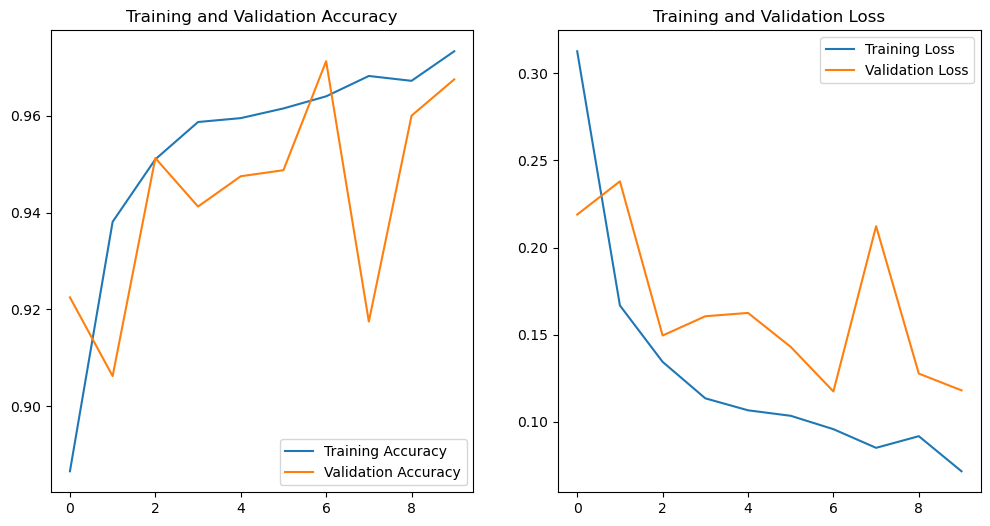

In [36]:
#melihat plot model
acc = history_seq_Ex.history['accuracy']
val_acc = history_seq_Ex.history['val_accuracy']

loss = history_seq_Ex.history['loss']
val_loss = history_seq_Ex.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

jika dilihat dari graph model memiliki maslah gradient exploding, mungkin dengan dropout masalah ini bisa teratasi 

In [99]:
#memcoba model dengan test set
test_results_1 = model_seq_Ex.evaluate(test_ds, verbose=0)
print(f'Test Loss model seq_emodel_seq_Ex     : {test_results_1[0]:.4f}')
print(f'Test Accuracy model seq_emodel_seq_Ex : {test_results_1[1]:.4f}')

Test Loss model seq_emodel_seq_Ex     : 0.4678
Test Accuracy model seq_emodel_seq_Ex : 0.8740


model malah memiliki accuracy yang lebih rendah dibandingkan dengan model sequential biasa.saya berasumsi ini terjadi karena model ini terlalu kompleks

In [83]:
# Predict probabilities
y_pred_test = model_seq_Ex.predict(test_ds)

# Convert probabilities to class labels
y_pred_class = (y_pred_test > 0.5).astype("int32")

# Assuming y_test is a numpy array or a pandas Series
y_test = test_data_df["label_encoded"]

# Print classification report
print(classification_report(y_test, y_pred_class))

16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.65       483
           1       0.00      0.00      0.00       509

    accuracy                           0.49       992
   macro avg       0.24      0.50      0.33       992
weighted avg       0.24      0.49      0.32       992



In [84]:
# prediksi dan evaluasi Model Improvement
y_pred_test = model_seq_Ex.predict(test_ds)
y_pred_test = y_pred_test.argmax(axis=1)
y_test = test_ds.classes
print(classification_report(y_test, y_pred_test))

16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.65       483
           1       0.00      0.00      0.00       509

    accuracy                           0.49       992
   macro avg       0.24      0.50      0.33       992
weighted avg       0.24      0.49      0.32       992



Score tidak berubah sama sekali dari model yang pertama

### Modelling dengan data augmentasi

Saya tidak bisa menggunakan syntax = Sequential(RandomFlip("horizontal",input_shape=inputs))  
karena saya menggunakan tensorflow versi 2.10.1 dan ketika saya cari tahu di internet dalam tensorflow versi ini Sequential tidak memiliki fungsi RandomFlip,RandomRotation, dan lain-lainn. dan saya tidak bisa upgrade tensorflow ke versi lebih tinggi karena saya menggunakan OS windows native

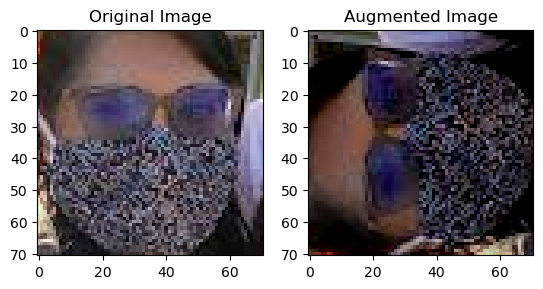

In [85]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image

# Mengambil gambar dari dataset
image = tf.image.decode_jpeg(tf.io.read_file('E:\\Project\\Face Mask Dataset\\Train\\WithMask\\7.png'))

# Augmentasi gambar
augmented_image = augment_image(image)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title('Augmented Image')

plt.show()

Pembalikan gambar diharapkan membuat model menjadi lebih robust

In [86]:
# Membuat objek ImageDataGenerator dengan konfigurasi augmentasi gambar
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

# Menerapkan augmentasi gambar pada data
augmented_data = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 10000 images belonging to 2 classes.


#### Model Seq Aug

In [87]:
seed=20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [88]:
inputs= (img_height, img_width,3)
model_seq_Aug = Sequential([
    layers.Conv2D(20, (5, 5), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(50, (5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model_seq_Aug.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model_seq_Aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 216, 216, 20)   │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 108, 108, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 104, 104, 50)   │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 52, 52, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 135200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    67,600,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,627,571 (257.98 MB)

 Trainable params: 67,627,571 (257.98 MB)

 Non-trainable params: 0 (0.00 B)

Penjelasan Model : Arsitektur model ini sama dengan model yang sequential pertama hanya diganti sumber datanya dengan data yang sudah di augmentasi

In [89]:
#training model
epochs=10
history_seq_Aug= model_seq_Aug.fit(
    augmented_data,
    validation_data= val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.5506 - loss: 563.8019 - val_accuracy: 0.5562 - val_loss: 0.6701
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.5811 - loss: 0.6710 - val_accuracy: 0.5725 - val_loss: 0.6543
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.6035 - loss: 0.6772 - val_accuracy: 0.6012 - val_loss: 0.6518
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.6536 - loss: 0.6176 - val_accuracy: 0.5763 - val_loss: 0.6501
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.6195 - loss: 0.6394 - val_accuracy: 0.6212 - val_loss: 0.6249
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.6699 - loss: 0.6007 - val_accuracy: 0.7650 - val_loss: 0.5279
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7098 - loss: 0.5653 - val_accuracy: 0.6212 - val_loss: 0.6649
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.6496 - loss: 0.6347 - val_ac

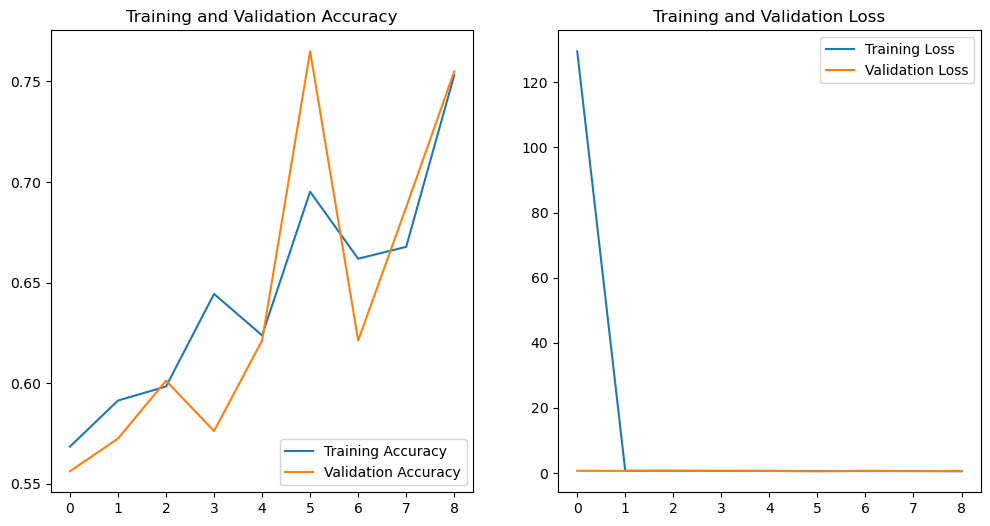

In [91]:
#melihat plot model
acc = history_seq_Aug.history['accuracy']
val_acc = history_seq_Aug.history['val_accuracy']

loss = history_seq_Aug.history['loss']
val_loss = history_seq_Aug.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model memiliki sifat yang sangat buruk dan memiliki gradient exploding yang besar

In [92]:
test_results_3 = model_seq_Aug.evaluate(test_ds, verbose=0)
print(f'Test Loss model seq_Aug     : {test_results_3[0]:.4f}')
print(f'Test Accuracy model seq_Aug : {test_results_3[1]:.4f}')

Test Loss model seq_Aug     : 0.5215
Test Accuracy model seq_Aug : 0.7692


In [93]:
# prediksi dan evaluasi Model Improvement
y_pred_test = model_seq_Aug.predict(test_ds)
print(y_pred_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step
[[7.89687097e-01]
 [9.99328554e-01]
 [3.83487135e-01]
 [7.60594368e-01]
 [4.75702912e-01]
 [4.61849213e-01]
 [5.47306538e-01]
 [5.32071948e-01]
 [5.45108795e-01]
 [1.61033541e-01]
 [2.34692216e-01]
 [1.50344014e-01]
 [7.29736090e-01]
 [3.97151619e-01]
 [2.75007963e-01]
 [2.26679265e-01]
 [6.97819471e-01]
 [5.45479298e-01]
 [9.19720232e-01]
 [9.13890675e-02]
 [9.29714262e-01]
 [0.00000000e+00]
 [6.29186928e-02]
 [4.93088692e-01]
 [1.11385591e-01]
 [1.20456733e-01]
 [8.15717410e-03]
 [1.12108532e-20]
 [5.85925812e-03]
 [5.10297716e-01]
 [5.36110401e-01]
 [4.62103248e-01]
 [7.83516765e-01]
 [5.89195013e-01]
 [6.42316997e-01]
 [4.55468744e-01]
 [3.63072872e-01]
 [1.21869680e-05]
 [4.87795651e-01]
 [5.99172004e-02]
 [4.78667704e-14]
 [9.25360143e-01]
 [4.25719559e-01]
 [2.71916866e-01]
 [2.77817756e-01]
 [4.60657835e-01]
 [2.14212731e-01]
 [7.05873132e-01]
 [5.12859941e-01]
 [4.60534304e-01]
 [1.15862571e-01]
 [3.72717738e-01]
 [9.95084763e-01]
 [5.3

model dengan data yang sudah di augmentasi memiliki nilai prediksi yang sangat kecil juga, tetapi lebih besar dibandingkan dengan data yang belum di augmentasi

In [94]:
# Predict probabilities
y_pred_test = model_seq_Aug.predict(test_ds)

# Convert probabilities to class labels
y_pred_class = (y_pred_test > 0.5).astype("int32")

# Assuming y_test is a numpy array or a pandas Series
y_test = test_data_df["label_encoded"]

# Print classification report
print(classification_report(y_test, y_pred_class))

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       483
           1       0.74      0.86      0.79       509

    accuracy                           0.77       992
   macro avg       0.78      0.77      0.77       992
weighted avg       0.78      0.77      0.77       992



score sama seperti ke 2 model lainya karena model tidak bisa sama sekali memprediksikan nilai 1 

#### Data Aug dengan Model Transfer Learning

Penjelasan Model : Model Menggunakan arsitektur yang sama seperti model exception yang sebelumnya hanya diganti train datanya saja

Saya akan mengurangi epoch karena pengerjaan dengan data augmentasi sangat lama dibandingkan dengan data yang tidak diaugmentasi

Model masih memiliki maslah yang sama yaitu gradient exploding


#### Melihat Skor antara seluruh Model

Test Loss model seq_noAug     : 8.9296  
Test Accuracy model seq_noAug : 0.4869  
________________________________________________    
Test Loss model_seq_Ex     : 18.1249  
Test Accuracy model_seq_Ex : 0.4869  
________________________________________________    
Test Loss model seq_Aug     : 4.0671  
Test Accuracy model seq_Aug : 0.4869  
________________________________________________    
Test Loss model_seq_Ex_aug     : 18.1249  
Test Accuracy model_seq_Ex_aug : 0.4869  

seluruh model memiliki  loss yang berbeda tetapi memiliki accuracy yangsama dikarenakan model bersifat underfitting. dan seluruh model tidak bisa memprediksi nilai 1(WithoutMask). ini mungkin disebabkan pemodelan yang tidak benar atau prepocessing data yang tidak benar.atau Loading data yang tidak benar

Text(0.5, 23.52222222222222, 'predict label')

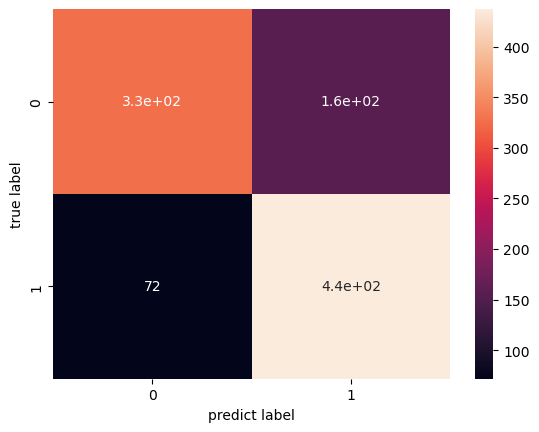

In [95]:
confusion = confusion_matrix(y_test, y_pred_class)

# Plot non-normalized confusion matrix
sns.heatmap(confusion, annot=True)
plt.ylabel('true label')
plt.xlabel('predict label')
     

>Kesimpulan Model 
1. Saya mencurigai permasalahanya ada dalam importing data. karena ketika saya melakukan importing data test dengan cara   
[ test_ds = tf.keras.preprocessing.image_dataset_from_directory(  
        test_path,  
        seed=444,  
        image_size=(img_height,img_width),  
        batch_size= batch_size,  
        shuffle=False  
)]   
hasil dari accuracy test sangatlah bagus. tetapi jika di import dengan seperti itu tidak bisa di dilihat classification score dan confusion matrixnya. saya akan coba kembali dengan cara import data dengan cara seperti itu

#### Membuat model dengan cara load model yang berbeda

In [96]:
# Preprocess data
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=444,
    image_size=(img_height,img_width),
    batch_size= batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=444,
    image_size=(img_height,img_width),
    batch_size= batch_size,
    shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=444,
    image_size=(img_height,img_width),
    batch_size= batch_size,
    shuffle=False
)


Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [97]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [98]:
seed=20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [99]:
inputs= (img_height, img_width,3)
model_seq = Sequential([
    layers.Rescaling(1./255, input_shape=inputs),
    layers.Conv2D(16 ,3 , padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32 ,3 , padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(units=1, activation='sigmoid')
])
model_seq.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model_seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 220, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,390,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,396,257 (47.29 MB)

 Trainable params: 12,396,001 (47.29 MB)

 Non-trainable params: 256 (1.00 KB)

In [100]:
#saya akan mengurangi epoch untuk menghemat waktu
epochs=30
history_seq= model_seq.fit(
    train_ds,
    validation_data= val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 499ms/step - accuracy: 0.9187 - loss: 0.2174 - val_accuracy: 0.9425 - val_loss: 0.1346
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 462ms/step - accuracy: 0.9816 - loss: 0.0516 - val_accuracy: 0.9650 - val_loss: 0.0866
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 477ms/step - accuracy: 0.9846 - loss: 0.0398 - val_accuracy: 0.9887 - val_loss: 0.0278
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 469ms/step - accuracy: 0.9920 - loss: 0.0223 - val_accuracy: 0.9887 - val_loss: 0.0351
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 478ms/step - accuracy: 0.9964 - loss: 0.0145 - val_accuracy: 0.9463 - val_loss: 0.1469
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 492ms/step - accuracy: 0.9962 - loss: 0.0103 - val_accuracy: 0.9850 - val_loss: 0.0650


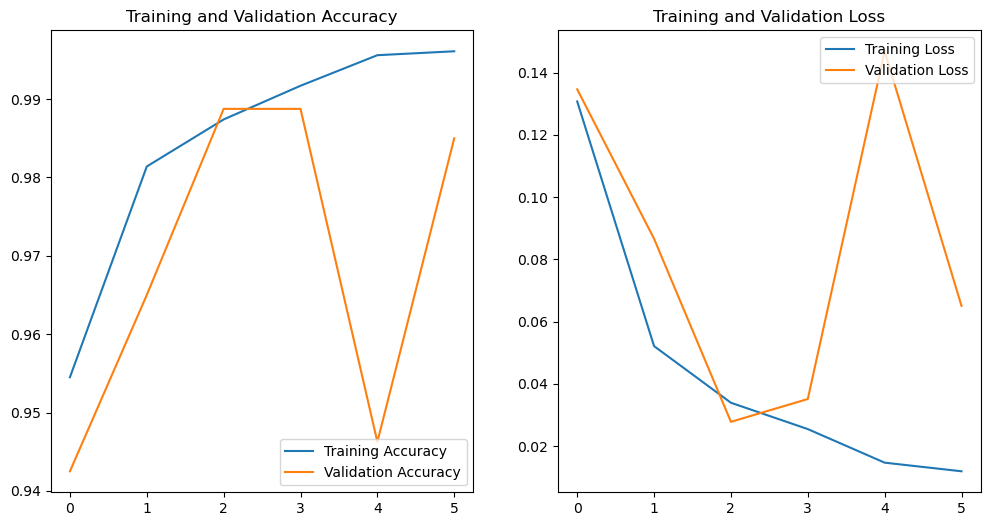

In [102]:
#melihat plot model
acc = history_seq.history['accuracy']
val_acc = history_seq.history['val_accuracy']

loss = history_seq.history['loss']
val_loss = history_seq.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

val loss tiba tiba naik secara tiba-tiba  mungkin karena model terlalu kompleks

In [ ]:
test_results_1 = model_seq.evaluate(test_ds, verbose=0)
print(f'Test Loss     : {test_results_1[0]:.4f}')
print(f'Test Accuracy : {test_results_1[1]:.4f}')

Test Loss     : 0.2495
Test Accuracy : 0.9194


In [103]:
# Predict probabilities
y_pred_test = model_seq.predict(test_ds)

# Convert probabilities to class labels
y_pred_class = (y_pred_test > 0.5).astype("int32")

# Assuming y_test is a numpy array or a pandas Series
y_test = test_data_df["label_encoded"]

# Print classification report
print(classification_report(y_test, y_pred_class))

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       483
           1       0.95      1.00      0.98       509

    accuracy                           0.97       992
   macro avg       0.98      0.97      0.97       992
weighted avg       0.98      0.97      0.97       992



saya gagal mengulang model yang pertamakali saya kerjakan  tidak diketahui kenapa padahal saya menggunakan codingan yang sama nanti saya akan lihat lebih lanjut apa perbedaan yang saya lakukan sekarang dengan yang saya lakukan saat pertama kali. jika dilihat accuracy model lebih baik dibandingkan dengan cara menggunakan data yang dimport dengan cara image data generator  saya akan menggunakan model ini untuk inferencing dan model deployment

## Kesimpulan

>Kesimpulan Model 
1. Saya mencurigai permasalahanya ada dalam importing data. karena ketika saya melakukan importing data test dengan cara   
[ test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=444,
    image_size=(img_height,img_width),
    batch_size= batch_size,
    shuffle=False  
)]  
 hasil dari accuracy test sangatlah bagus. tetapi jika di import dengan seperti itu tidak bisa di dilihat classification score dan confusion matrixnya

2. Kita tidak tahu peforma sebenarnya dari model terakhir classification scorenya karena saya gagal untuk melihat classification scorenya

3. Jika berpegang dengan model-model yang menggunakan import data dengan cara pertama model model ini semua bepeforma sangat buruk karena tidak bisa mengenali kelas ke 1. semua jawaban diprediksikan ke kelas 0 

4. Karena saya menggunakan tensorflow versi 2.10.1 banyak fitur fitur yang ada di tensorflow yang baru yang saya tidak bisa gunakan. 

5. Setelah dilakukan Inferencing model_seq juga tetap tidak bisa memprediksi wajah tanpa masker meskipun saat evaluasi terlihat memiliki score accuracy yang besar. tetapi jika dilihat dari graph memang sudah terlihat bahwa model akan memilki peforma yang buruk

6. Maka saat ini saya hanya bisa menjadikan model ini sebagai pembelajaran untuk pembuatan model CNN kedepanya 

> Bussiness Implementation  

1. Semua model tidak bisa digunakan untuk bisnis karena semuanya memiliki sifat underfitting.  

2. Mungkin Model terakhir yang saya buat (model_seq) bisa untuk digunakan untuk keperluan bisnis, tapi ini harus diteliti lebih lanjut karena saya tidak mengetahui classification scorenya,dan ROC,AUC. hanya mengetahu accuracy scorenya saja 

> Future Improvement

1. Jika waktu ada lebih banya saya akan mencoba menggunakan model lainya seperti functional. dan saya juga akan mencoba untuk memakai transfer learning yang lain.

2. Saya banyak mendapatkan kendala karena saya menggunakan tensorflow yang versi lama, jadi kedepanya jika saya akan membuat model CNN saya akan menggunakan Google Colab jika saya belum membenarkan Virtual Env saya dan juga belum merubah OS saya ke linux agar bisa upgrade tensorflow

3. Dugaan pertama saya model ini memiliki peforma yang buruk dikarenakan proses prepocessing data atau importing data yang kurang tepat. oleh karena itu jika membuat model seperti ini lagi saya akan mengubah itu pertama kali

## Save Model

In [ ]:
#freeze Model
model_seq.trainable=False
model_seq.summary()

#save Model
model_seq.save("model_seq_2.h5")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 96800)             0